In [6]:
using Pkg
# Pkg.add("Profile")
# Pkg.instantiate()

In [7]:
#= dependencies = ["DelimitedFiles", "LinearAlgebra", "Optim", "Distributions", "Test",
                "BenchmarkTools", "Random", "CSV", "DataFrames", "Distributed", "Plots"];
Pkg.add(dependencies) =#

In [8]:
using DelimitedFiles
using LinearAlgebra
using Optim
using Distributions
using Test
using BenchmarkTools
using Random
using CSV
using DataFrames
using Plots
using Profile
using Distributed

In [9]:
pwd()

"/Users/FredYu/Documents/GitHub/BulkLMM.jl/analysis"

In [60]:
## Include the source code of BulkLMM to be tested:
include("../src/scan.jl");
include("../src/lmm.jl");
include("../src/wls.jl");
include("../src/util.jl");
include("../src/kinship.jl");
include("../src/readData.jl");
include("../src/scan_for_tests.jl")
include("../src/scan_distributed.jl") # new function

## Also include the helper functions for writing tests:
include("../test/testHelper.jl");

In [11]:
## Read in BXD data:
pheno_file = "../data/bxdData/BXDtraits.csv"
pheno = readBXDpheno(pheno_file);
geno_file = "../data/bxdData/BXDgeno_prob.csv"
geno = readGenoProb_ExcludeComplements(geno_file);

kinship = calcKinship(geno); # calculate kinship matrix from genotype data

In [43]:
m = size(pheno, 2);
(n, p) = size(geno); # number of markers

In [8]:
## Consider the 7919-th trait
pheno_y = reshape(pheno[:, 7919], :, 1);

In [9]:
n_seeds = 20;

In [10]:
using StatsBase

In [11]:
seeds_list = StatsBase.sample(1:100, n_seeds; replace = false);

In [12]:
(y0, X0, lambda0) = transform1(pheno_y, geno, kinship);

In [13]:
(r0, X00) = transform2(y0, X0, lambda0; reml = false);

In [14]:
# addprocs(10);

In [15]:
workers()

10-element Vector{Int64}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

In [16]:
# rmprocs(workers())

In [17]:
@everywhere begin
    using Random
    using LinearAlgebra
    using Optim
    using Distributed
    
    ## Include the source code of BulkLMM to be tested:
    include("../src/scan.jl");
    include("../src/lmm.jl");
    include("../src/wls.jl");
    include("../src/util.jl");
    include("../src/kinship.jl");
    include("../src/readData.jl");
    include("../src/scan_for_tests.jl")
    include("../src/scan_distributed.jl")

    include("../src/parallel_helpers.jl")
end

In [18]:
LODs_by_blocks = scan_perms_distributed(pheno_y, geno, kinship; reml = false, nperms = 1000, rndseed = 0, original = true, 
    option = "by blocks", nblocks = 1000);

In [19]:
LODs_ordinary = scan_perms(pheno_y, geno, kinship; reml = false, nperms = 1000, rndseed = 0, original = true);

In [20]:
LODs_by_nperms = scan_perms_distributed(pheno_y, geno, kinship; reml = false, nperms = 1000, original = true, 
    option = "by nperms", ncopies = 10);

In [25]:
LODs_by_blocks[1:6, :]

6×7321 Matrix{Float64}:
 0.00819636  0.00819636  0.00819636  …  0.0449878  0.0128283  0.0128283
 0.604956    0.604956    0.604956       1.33928    1.29426    1.29426
 0.0264842   0.0264842   0.0264842      0.16927    0.069518   0.069518
 0.00585467  0.00585467  0.00585467     0.589608   0.14854    0.14854
 0.477297    0.477297    0.477297       0.0317133  0.0625366  0.0625366
 0.140293    0.140293    0.140293    …  0.0400303  0.0338204  0.0338204

In [26]:
LODs_ordinary[1:6, :]

6×7321 Matrix{Float64}:
 0.00819636  0.00819636  0.00819636  …  0.0449878  0.0128283  0.0128283
 0.604956    0.604956    0.604956       1.33928    1.29426    1.29426
 0.0264842   0.0264842   0.0264842      0.16927    0.069518   0.069518
 0.00585467  0.00585467  0.00585467     0.589608   0.14854    0.14854
 0.477297    0.477297    0.477297       0.0317133  0.0625366  0.0625366
 0.140293    0.140293    0.140293    …  0.0400303  0.0338204  0.0338204

In [27]:
LODs_by_nperms[1:6, :]

6×7321 Matrix{Float64}:
 0.00819636  0.00819636  0.00819636  …  0.0449878   0.0128283   0.0128283
 0.0216736   0.0216736   0.0216736      0.228459    0.229219    0.229219
 0.00367439  0.00367439  0.00367439     0.0355759   0.0113422   0.0113422
 0.0915744   0.0915744   0.0915744      4.88055e-5  0.00721153  0.00721153
 0.263331    0.263331    0.263331       0.246703    0.343597    0.343597
 0.00102973  0.00102973  0.00102973  …  0.118041    0.152828    0.152828

In [21]:
maxSqDiff(LODs_by_blocks, LODs_ordinary)

7.888609052210118e-29

In [57]:
p

7321

In [74]:
floor(Int, 11/3)

3

In [73]:
11%3

2

In [63]:
7321%150

121

In [59]:
createBlocks(p, 150)

150-element Vector{UnitRange{Int64}}:
 1:48
 49:96
 97:144
 145:192
 193:240
 241:288
 289:336
 337:384
 385:432
 433:480
 481:528
 529:576
 577:624
 ⋮
 6625:6672
 6673:6720
 6721:6768
 6769:6816
 6817:6864
 6865:6912
 6913:6960
 6961:7008
 7009:7056
 7057:7104
 7105:7152
 7153:7321

In [60]:
createBlocks2(p, ceil(Int, p/150))

150-element Vector{UnitRange{Int64}}:
 1:49
 50:98
 99:147
 148:196
 197:245
 246:294
 295:343
 344:392
 393:441
 442:490
 491:539
 540:588
 589:637
 ⋮
 6763:6811
 6812:6860
 6861:6909
 6910:6958
 6959:7007
 7008:7056
 7057:7105
 7106:7154
 7155:7203
 7204:7252
 7253:7301
 7302:7321

In [66]:
@benchmark scan_perms_distributed(pheno_y, geno, kinship; reml = false, nperms = 150, rndseed = 0, original = true, 
    option = "by blocks", nblocks = 150)

BenchmarkTools.Trial: 18 samples with 1 evaluation.
 Range (min … max):  267.491 ms … 307.450 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     282.047 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   283.897 ms ±  12.539 ms  ┊ GC (mean ± σ):  0.63% ± 1.53%

  ▁ ▁▁▁   ▁   ▁   ▁ ▁ ▁  ▁  ▁▁ ▁              █        █      ▁  
  █▁███▁▁▁█▁▁▁█▁▁▁█▁█▁█▁▁█▁▁██▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█ ▁
  267 ms           Histogram: frequency by time          307 ms <

 Memory estimate: 44.51 MiB, allocs estimate: 13274.

In [65]:
@benchmark scan_perms_distributed(pheno_y, geno, kinship; reml = false, nperms = 1000, rndseed = 0, original = true, 
    option = "by blocks", nblocks = 150)

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  489.938 ms … 539.166 ms  ┊ GC (min … max): 0.71% … 0.00%
 Time  (median):     500.392 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   505.726 ms ±  16.178 ms  ┊ GC (mean ± σ):  0.34% ± 0.44%

  ██     █ █  ██   █      █                       █           █  
  ██▁▁▁▁▁█▁█▁▁██▁▁▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█ ▁
  490 ms           Histogram: frequency by time          539 ms <

 Memory estimate: 140.61 MiB, allocs estimate: 15097.

In [64]:
@benchmark scan_perms_distributed(pheno_y, geno, kinship; reml = false, nperms = 4000, rndseed = 0, original = true, 
    option = "by blocks", nblocks = 150)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.600 s …    2.789 s  ┊ GC (min … max): 0.32% … 0.15%
 Time  (median):     2.694 s               ┊ GC (median):    0.23%
 Time  (mean ± σ):   2.694 s ± 133.610 ms  ┊ GC (mean ± σ):  0.23% ± 0.12%

  █                                                        █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.6 s          Histogram: frequency by time         2.79 s <

 Memory estimate: 479.70 MiB, allocs estimate: 19788.

In [23]:
@benchmark scan_perms(pheno_y, geno, kinship; reml = false, nperms = 1000, rndseed = 0, original = true)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.809 s …   2.832 s  ┊ GC (min … max): 5.75% … 6.13%
 Time  (median):     2.820 s              ┊ GC (median):    5.94%
 Time  (mean ± σ):   2.820 s ± 16.629 ms  ┊ GC (mean ± σ):  5.94% ± 0.27%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.81 s         Histogram: frequency by time        2.83 s <

 Memory estimate: 13.30 GiB, allocs estimate: 74635.

In [32]:
@benchmark scan_null(pheno_y, geno, kinship)

BenchmarkTools.Trial: 77 samples with 1 evaluation.
 Range (min … max):  42.756 ms … 120.028 ms  ┊ GC (min … max):  0.00% … 57.37%
 Time  (median):     59.999 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):   65.711 ms ±  21.083 ms  ┊ GC (mean ± σ):  14.37% ± 19.88%

  ▁            █▃                                               
  █▁▄▃▁▄▄▃▁▁▄▁▄██▃▄▅▄▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▄▃▁▁▃▁▃▃▁▃▄ ▁
  42.8 ms         Histogram: frequency by time          118 ms <

 Memory estimate: 33.23 MiB, allocs estimate: 73607.

In [35]:
m

35556

In [75]:
m*60*1e-3

2133.36

In [76]:
@time begin
    for i in 1:m
        pheno_yi = reshape(pheno[:, i], :, 1);
        scan_null(pheno_yi, geno, kinship);
    end
end

LoadError: InterruptException:

In [41]:
heritabilities = Array{Float64, 1}(undef, m);

In [45]:
intercept = ones(n, 1);
(Y0, X0, lambda0) = rotateData(pheno, [intercept geno], kinship);

In [46]:
size(Y0)

(79, 35556)

In [47]:
size(X0) # intercept + 7321 markers

(79, 7322)

In [49]:
intercept0 = reshape(X0[:, 1], :, 1);
size(intercept0)

(79, 1)

In [77]:
@time begin
for i in 1:m
    y0_i = reshape(Y0[:, i], :, 1); # the i-th (rotated) trait
    heritabilities[i] = fitlmm(y0_i, intercept0, lambda0; reml = true).h2;
end
end

 13.553209 seconds (32.12 M allocations: 12.682 GiB, 14.10% gc time)


In [52]:
using Plots

$$h_i^2 = \frac{\sigma_{gi}^2}{\sigma^2_{ei} + \sigma^2_{gi}}$$

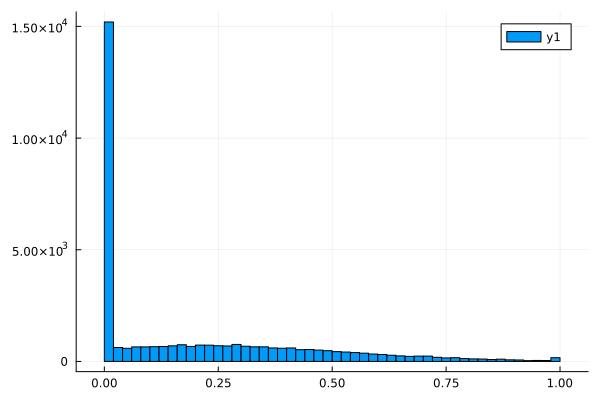

In [53]:
histogram(heritabilities)

In [2]:
1.42894/(1.42894+0.344439)

0.8057724829266615

In [15]:
x = [1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0.5, 0, 1, 0, 1, 0.5, 0, 1, 0, 0, 0, 1, 1, 0, 0.5, 1, 1, 0.5, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0.5, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0.5, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 1, 0, 1, 0, 0, 1, 0.5, 0, 1, 0.5, 0.5];

In [28]:
sum(geno[1:20, 1] - x[1:20] .> 0.1)

0

In [24]:
hcat(geno[1:30, 1], x[1:30])

79×2 Matrix{Float64}:
 1.0          1.0
 1.0          1.0
 5.18083e-11  0.0
 5.18083e-11  0.0
 5.18083e-11  0.0
 1.0          1.0
 1.0          1.0
 5.18083e-11  0.0
 1.0          1.0
 1.0          1.0
 5.18083e-11  0.0
 5.18083e-11  0.0
 1.0          1.0
 ⋮            
 5.18083e-11  0.0
 5.18083e-11  0.0
 1.0          1.0
 1.0          0.0
 1.0          1.0
 1.0          0.0
 5.18083e-11  0.0
 1.0          0.0
 1.0          1.0
 1.0          1.0
 1.0          1.0
 1.0          0.0

In [12]:
geno[:, 1]

79-element Vector{Float64}:
 0.999999999948191
 0.999999999948193
 5.18083214030656e-11
 5.18083214030656e-11
 5.18083214030656e-11
 0.999999999948193
 0.999999999948191
 5.18083214030656e-11
 0.999999999948191
 0.999999999948191
 5.18083214030656e-11
 5.18083214030656e-11
 0.999999999948191
 ⋮
 5.18083214030656e-11
 5.18083214030656e-11
 0.999999999948191
 0.999999999948191
 0.999999999948194
 0.999999999948194
 5.18083214030656e-11
 0.999999999948194
 0.999999999948194
 0.999999999948194
 0.999999999948194
 0.999999999948194

In [32]:
geno_file = "../data/bxdData/BXDgeno_prob.csv"

"../data/bxdData/BXDgeno_prob.csv"

In [ ]:
include("../src/readData.jl");

In [61]:
geno_full = readGenoProb(geno_file);
geno_4_gemma = transform_bxd_geno_to_gemma(geno_file, "whateva");
## minor allele: A (encoded as 1), also the effect allele
## major allele: B (encoded as 0).

In [64]:
geno_4_gemma[:, :]

7321×82 Matrix{Any}:
 "rs31443144:AA"     "A"  "B"  2.0  …  2.0          2.0  2.0          2.0
 "rs6269442:AA"      "A"  "B"  2.0     2.0          2.0  2.0          2.0
 "rs32285189:AA"     "A"  "B"  2.0     2.0          2.0  2.0          2.0
 "rs258367496:AA"    "A"  "B"  2.0     2.0          2.0  2.0          2.0
 "rs32430919:AA"     "A"  "B"  2.0     2.0          2.0  2.0          2.0
 "rs36251697:AA"     "A"  "B"  2.0  …  2.0          2.0  2.0          2.0
 "rs30658298:AA"     "A"  "B"  2.0     2.0          2.0  2.0          2.0
 "rs51852623:AA"     "A"  "B"  2.0     2.0          2.0  2.0          2.0
 "rs31879829:AA"     "A"  "B"  2.0     2.0          2.0  2.0          2.0
 "rs36742481:AA"     "A"  "B"  2.0     2.0          2.0  2.0          2.0
 "rs6365999:AA"      "A"  "B"  2.0  …  2.0          2.0  2.0          2.0
 "rs13470446:AA"     "A"  "B"  2.0     2.0          2.0  2.0          2.0
 "Affy_10344635:AA"  "A"  "B"  2.0     2.0          2.0  2.0          2.0
 ⋮               

In [66]:
st_sets = ["Geeks", "Fred"]

2-element Vector{String}:
 "Geeks"
 "Fred"

In [68]:
println(map(x -> SubString(x, 1, 3), st_sets))

SubString{String}["Gee", "Fre"]


In [47]:
hcat(geno_4_gemma[1, 4:end], geno[:, 1])

79×2 Matrix{Any}:
 2.0          1.0
 2.0          1.0
 1.03617e-10  5.18083e-11
 1.03617e-10  5.18083e-11
 1.03617e-10  5.18083e-11
 2.0          1.0
 2.0          1.0
 1.03617e-10  5.18083e-11
 2.0          1.0
 2.0          1.0
 1.03617e-10  5.18083e-11
 1.03617e-10  5.18083e-11
 2.0          1.0
 ⋮            
 1.03617e-10  5.18083e-11
 1.03617e-10  5.18083e-11
 2.0          1.0
 2.0          1.0
 2.0          1.0
 2.0          1.0
 1.03617e-10  5.18083e-11
 2.0          1.0
 2.0          1.0
 2.0          1.0
 2.0          1.0
 2.0          1.0